# Decision Tree

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
#Reading in the data
twitter_cleaned = pd.read_csv("cleaned_twitter.csv", low_memory = False)

# Checking if the data is correctly read in
twitter_cleaned

,sub_index,utype,domain,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,...,org_med_combined,org_med_np_combined,org_med_vp_combined,exmark_combined,first,interj,slang,sentiment,active_vb,semi_combined
0,1.503432,between100-10msgs,Technology,1796.0,165.0,45.0,3.043836,100.669173,0.131579,4.026316,...,3.0,2.0,0.0,0.000000,0.086957,1.000000,0.260870,0.043478,0.217391,0.105263
1,3.266043,morethan100msgs,Fitness,1699.0,1023.0,352.0,2.126027,132.244318,0.073864,4.784091,...,5.0,2.0,3.0,0.386364,0.629412,0.400000,1.311765,0.282353,0.347059,0.090909
2,0.000000,morethan100msgs,Technology,6382.0,6244.0,5.0,5.227397,61.200000,0.000000,2.000000,...,2.0,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.892857,Random,Unknown,622.0,823.0,7.0,5.926027,139.857143,0.142857,4.571429,...,5.0,3.0,4.0,0.142857,0.750000,0.250000,1.250000,0.500000,0.000000,0.000000
4,2.595833,between10-3msgs,Technology,238.0,233.0,19.0,6.800000,129.625000,0.062500,2.500000,...,8.5,2.5,7.0,0.062500,0.133333,0.133333,0.533333,1.000000,0.733333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4498,1.991667,mentioned,Science,6517.0,530.0,18.0,6.482192,120.600000,0.066667,3.733333,...,6.0,3.5,4.0,0.133333,0.500000,0.500000,0.750000,0.125000,0.250000,0.266667
4499,3.482211,morethan100msgs,Fitness,283.0,65.0,2342.0,1.846575,118.715223,0.066431,5.100647,...,2.5,2.0,2.0,0.395657,0.483189,1.878525,0.674620,0.039588,0.056941,0.046310
4500,0.000000,friend,Fitness,1560.0,1996.0,1.0,7.704110,51.000000,0.000000,2.000000,...,2.0,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4501,4.485965,mentioned,Science,364.0,396.0,24.0,5.364384,117.094737,0.436842,4.110526,...,7.5,2.0,6.0,0.436842,0.444444,1.666667,1.777778,0.166667,0.277778,0.284211


In [3]:
# Checking subjectivity index properties
print(min(twitter_cleaned['sub_index']))
print(max(twitter_cleaned['sub_index']))
print(np.mean(twitter_cleaned['sub_index']))

-4.0
18.0
2.1266694884148367


# Determining Label For Classification
The subjectivity index is broken into three equal frequency bins for labelling -> [Low, Medium, High]

In [4]:
subIndex_df = twitter_cleaned['sub_index']

numTotalElements = int(len(subIndex_df.tolist()))
numElementPartition = int(numTotalElements/2)

# Label Array
non_subjective_label = [0 for x in range(numElementPartition)]
subjective_label = [1 for x in range(numElementPartition+1)]
label = non_subjective_label + subjective_label

# Number of elements in labels (split in middle (median))
print(numElementPartition)

2251


# Construct relevant dataframe with label


In [5]:
decisionTree_df = twitter_cleaned.set_index('sub_index')
decisionTree_df = decisionTree_df.sort_values('sub_index')
decisionTree_df['label'] = label

# Drop all columns used to construct subjectivity index
decisionTree_df = decisionTree_df.drop(columns=['exmark_combined', 'first', 'interj', 
                                                'slang', 'sentiment', 'active_vb',
                                                'semi_combined'])

# Temp drop inf values (Discuss significance of dropping before or after labelling)
decisionTree_df.replace([np.inf, -np.inf], np.nan, inplace=True)
decisionTree_df.dropna(inplace=True)

# Convert utype and domain categorical data into encoded values (@MEIMI HERE!!)
ohe1, ohe2 = OneHotEncoder(), OneHotEncoder()
utype_encoded = ohe1.fit_transform(decisionTree_df[['utype']])
domain_encoded = ohe2.fit_transform(decisionTree_df[['domain']])

# Append new encoded categories into subIndex_df
UTYPE_FEATURES = ohe1.categories_[0].tolist()
DOMAIN_FEATURES = ohe2.categories_[0].tolist()
decisionTree_df[UTYPE_FEATURES] = utype_encoded.toarray()
decisionTree_df[DOMAIN_FEATURES] = domain_encoded.toarray()

print(decisionTree_df.keys())
print(len(UTYPE_FEATURES))
print(len(DOMAIN_FEATURES))

decisionTree_df

Index(['utype', 'domain', 'followers', 'friends', 'total_tweets', 'years',
       'chars_combined', 'quesmark_combined', 'punc_combined',
       'tagpermsg_combined', 'mentpermsg_combined',
       'percent_msgwithment_combined', 'percent_msgwithtag_combined',
       'percent_msgwithurl_combined', 'org_med_combined',
       'org_med_np_combined', 'org_med_vp_combined', 'label', 'Random',
       'between10-10msgs', 'between10-3msgs', 'between100-10msgs', 'expert',
       'friend', 'mentioned', 'morethan100msgs', 'Business', 'Fitness',
       'Science', 'Technology', 'Unknown'],
      dtype='object')
8
5


,utype,domain,followers,friends,total_tweets,years,chars_combined,quesmark_combined,punc_combined,tagpermsg_combined,...,between100-10msgs,expert,friend,mentioned,morethan100msgs,Business,Fitness,Science,Technology,Unknown
sub_index,,,,,,,,,,,,,,,,,,,,,
-4.000000,Random,Unknown,712.0,560.0,1.0,4.002740,108.000000,0.000000,6.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-2.000000,morethan100msgs,Technology,1647.0,249.0,170.0,2.394521,104.088235,0.000000,7.000000,4.017647,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
-1.678473,morethan100msgs,Technology,5139.0,5911.0,759.0,4.550685,92.110738,0.014765,4.766012,0.493960,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
-1.040000,mentioned,Fitness,1407.0,1810.0,25.0,7.202740,118.080000,0.200000,10.840000,0.040000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
-1.000000,friend,Technology,1173.0,2000.0,1.0,7.345205,115.000000,0.000000,4.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13.000000,Random,Unknown,648.0,475.0,1.0,2.476712,138.000000,0.000000,7.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14.476923,morethan100msgs,Fitness,153.0,0.0,130.0,5.673973,113.969231,0.000000,6.000000,2.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15.000000,Random,Unknown,1256.0,429.0,1.0,3.473973,124.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Build Decision Tree Model (ALWAYS RUN FROM HERE)
Let's first build a raw decision tree (with no techniques in increasing accuracy and decreasing over-fitting) and test it's accuracy

['followers', 'friends', 'total_tweets', 'years', 'chars_combined', 'quesmark_combined', 'punc_combined', 'tagpermsg_combined', 'mentpermsg_combined', 'percent_msgwithment_combined', 'percent_msgwithtag_combined', 'percent_msgwithurl_combined', 'org_med_combined', 'org_med_np_combined', 'org_med_vp_combined', 'Random', 'between10-10msgs', 'between10-3msgs', 'between100-10msgs', 'expert', 'friend', 'mentioned', 'morethan100msgs', 'Business', 'Fitness', 'Science', 'Technology', 'Unknown']
28
Accuracy:  0.632630410654828
10-fold accuracy:  0.6597812269031781


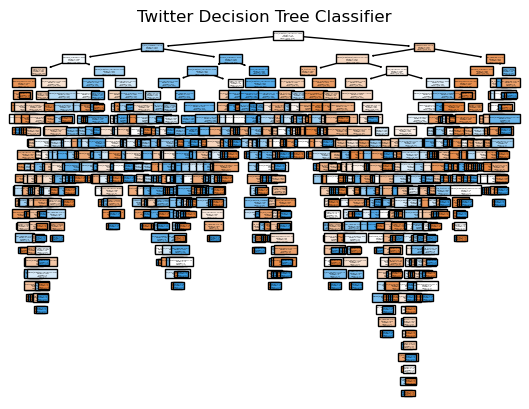

In [6]:
dt_twitter = DecisionTreeClassifier(criterion='entropy')
FEATURES = list(decisionTree_df.columns.values)
FEATURES.remove('label')
FEATURES.remove('utype')
FEATURES.remove('domain')
MAIN_FEATURES = FEATURES.copy()

print(FEATURES)
print(len(FEATURES))

label = [0,1]
X = decisionTree_df[FEATURES]
y = decisionTree_df['label']

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
dt_twitter.fit(X_train, y_train)

print("Accuracy: ", dt_twitter.score(X_test, y_test))

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(dt_twitter, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print("10-fold accuracy: ", np.mean(scores))
plot_tree(dt_twitter,
          feature_names=FEATURES,
          class_names=['0', '1'],
          filled=True,)
plt.title("Twitter Decision Tree Classifier")
plt.show()

Let's start over and incorporate more techniques in simplifying and increasing the accuracy of our decision tree

# Constructing the Best Decision Tree Model
Let's start with feature selection. We will iteratively remove each variable from the model and note the reduction in accuracy. We will do this until accuracy decreases significantly

In [7]:
def buildDecisionTree(X, y, dt_twitter, kfold):
    # Split data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
    dt_twitter.fit(X_train, y_train)

    # Perform K-fold cross-val and check accuracy
    if kfold:
        cv = KFold(n_splits=10, shuffle=True, random_state=42)
        scores = cross_val_score(dt_twitter, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        return np.mean(scores)
    else:
        return dt_twitter.score(X_test, y_test)
        # print("Accuracy: ", dt_twitter.score(X_test, y_test))

In [8]:
def iterativeFeatureRemovalWithEncoding(decisionTree_df, CURR_FEATURES, y, dt_twitter, UTYPE_FEATURES, DOMAIN_FEATURES, inclUTYPE, inclDOMAIN):
    label = [0,1]
    y = decisionTree_df['label']
    var_accuracy = list()

    # Check each (non-encoded) variable's impact on accuracy of decision tree
    TEMP_FEATURES = CURR_FEATURES.copy()
    NON_ENCODED_FEAT = CURR_FEATURES.copy()
    for element in TEMP_FEATURES:
        if ((element in UTYPE_FEATURES) or (element in DOMAIN_FEATURES)):
            NON_ENCODED_FEAT.remove(element)
    for variable in NON_ENCODED_FEAT:
        dt_twitter = DecisionTreeClassifier(criterion='entropy', random_state=42)#, max_depth=10)
        TEMP_FEATURES = CURR_FEATURES.copy()
        TEMP_FEATURES.remove(variable)
        X = decisionTree_df[TEMP_FEATURES]

        accuracy = buildDecisionTree(X, y, dt_twitter, True)
        var_accuracy.append([variable, accuracy])
    
    # Check utype (encoded variable)'s impact on accuracy of decision tree
    if inclUTYPE:
        curr_var = 'utype'
        TEMP_FEATURES = CURR_FEATURES.copy()
        for category in UTYPE_FEATURES:
            TEMP_FEATURES.remove(category)
        X = decisionTree_df[TEMP_FEATURES]
        dt_twitter = DecisionTreeClassifier(criterion='entropy', random_state=42)
        accuracy = buildDecisionTree(X, y, dt_twitter, True)
        var_accuracy.append([curr_var, accuracy])

    # Check domain (encoded variable)'s impact on accuracy of decision tree
    if inclDOMAIN:
        curr_var = 'domain'
        TEMP_FEATURES = CURR_FEATURES.copy()
        for category in DOMAIN_FEATURES:
            TEMP_FEATURES.remove(category)
        X = decisionTree_df[TEMP_FEATURES]
        dt_twitter = DecisionTreeClassifier(criterion='entropy', random_state=42)
        accuracy = buildDecisionTree(X, y, dt_twitter, True)
        var_accuracy.append([curr_var, accuracy])

    # Sort to find highest accuracy (meaning least impactful variable)
    var_accuracy.sort(key=lambda x: x[1], reverse=True)
    print(f"The variable to remove is: {var_accuracy[0][0]}, at mean score: {var_accuracy[0][1]}")
    return var_accuracy[0]

In [9]:
CURR_FEATURES = FEATURES.copy()
display(CURR_FEATURES)
inclUTYPE = True
inclDOMAIN = True

result_acc_score = []

for _ in range(0, 17):
    remove_variable = iterativeFeatureRemovalWithEncoding(decisionTree_df, CURR_FEATURES,
                        y, dt_twitter, UTYPE_FEATURES, DOMAIN_FEATURES, inclUTYPE, inclDOMAIN)
    result_acc_score.append(remove_variable[1])
    remove_variable = remove_variable[0]
    

    if (remove_variable == 'domain'):
        inclDOMAIN = False
    elif (remove_variable == 'utype'):
        inclUTYPE = False
    else:
        CURR_FEATURES.remove(remove_variable)

['followers',
 'friends',
 'total_tweets',
 'years',
 'chars_combined',
 'quesmark_combined',
 'punc_combined',
 'tagpermsg_combined',
 'mentpermsg_combined',
 'percent_msgwithment_combined',
 'percent_msgwithtag_combined',
 'percent_msgwithurl_combined',
 'org_med_combined',
 'org_med_np_combined',
 'org_med_vp_combined',
 'Random',
 'between10-10msgs',
 'between10-3msgs',
 'between100-10msgs',
 'expert',
 'friend',
 'mentioned',
 'morethan100msgs',
 'Business',
 'Fitness',
 'Science',
 'Technology',
 'Unknown']

The variable to remove is: friends, at mean score: 0.6651066765213107
The variable to remove is: percent_msgwithtag_combined, at mean score: 0.6731061837891107
The variable to remove is: followers, at mean score: 0.6688839615668885
The variable to remove is: punc_combined, at mean score: 0.6691047055925105
The variable to remove is: utype, at mean score: 0.6699990145355998
The variable to remove is: years, at mean score: 0.6673372751909337
The variable to remove is: percent_msgwithment_combined, at mean score: 0.669769894062577
The variable to remove is: total_tweets, at mean score: 0.670449371766445
The variable to remove is: org_med_vp_combined, at mean score: 0.6688874106922889
The variable to remove is: mentpermsg_combined, at mean score: 0.6684542990884454
The variable to remove is: org_med_combined, at mean score: 0.6662271495442228
The variable to remove is: org_med_np_combined, at mean score: 0.6575570337521557
The variable to remove is: tagpermsg_combined, at mean score: 0.648

/usr/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


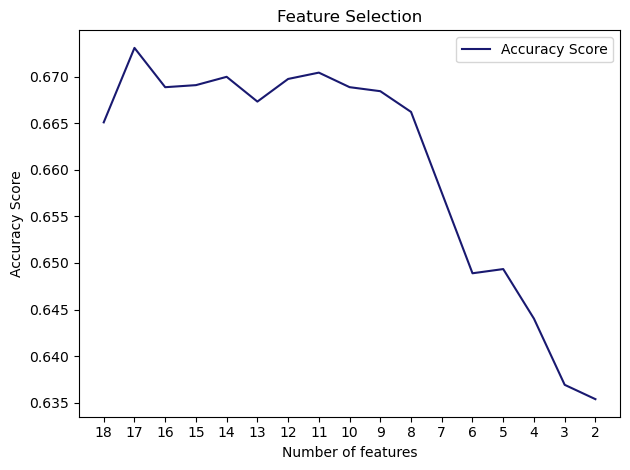

In [10]:
# Plot the accuracy accordinng to feature Selection

line_plot = sns.lineplot([18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2],result_acc_score, color = "midnightblue", label = "Accuracy Score")

line_plot.set_xticks([18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2])

line_plot.invert_xaxis()
plt.xlabel("Number of features")
plt.ylabel("Accuracy Score")
plt.title("Feature Selection")
plt.tight_layout()
plt.savefig('decision Tree Graphs/fea_selection_acc.png')
plt.savefig('decision Tree Graphs/fea_selection_acc.pdf')
plt.show()


**The Features to Use**


In [11]:
'''
The variable to remove is: friends, at mean score: 0.6651066765213107
The variable to remove is: percent_msgwithtag_combined, at mean score: 0.6731061837891107
The variable to remove is: followers, at mean score: 0.6688839615668885
The variable to remove is: punc_combined, at mean score: 0.6691047055925105
The variable to remove is: utype, at mean score: 0.6699990145355998
The variable to remove is: years, at mean score: 0.6673372751909337
The variable to remove is: percent_msgwithment_combined, at mean score: 0.669769894062577
The variable to remove is: total_tweets, at mean score: 0.670449371766445
The variable to remove is: org_med_vp_combined, at mean score: 0.6688874106922889
The variable to remove is: mentpermsg_combined, at mean score: 0.6684542990884454
'''

FEATURES = list(decisionTree_df.columns.values)
FEATURES.remove('label')
FEATURES.remove('utype')
FEATURES.remove('domain')

# Note: Must Run-all code for it to work
FEATURES.remove('years')
FEATURES.remove('percent_msgwithtag_combined')
FEATURES.remove('friends')
FEATURES.remove('followers')
FEATURES.remove('org_med_vp_combined')
FEATURES.remove('percent_msgwithment_combined')
FEATURES.remove('punc_combined')
FEATURES.remove('total_tweets')
FEATURES.remove('mentpermsg_combined')

for feature in UTYPE_FEATURES:
    FEATURES.remove(str(feature)) 


print(FEATURES)



X = decisionTree_df[FEATURES]
buildDecisionTree(X, y, dt_twitter, False)


['chars_combined', 'quesmark_combined', 'tagpermsg_combined', 'percent_msgwithurl_combined', 'org_med_combined', 'org_med_np_combined', 'Business', 'Fitness', 'Science', 'Technology', 'Unknown']


0.6315205327413984

# Sensitivity Analysis for Maximum Depth of Tree

In [12]:
MIN_DEPTH = 1
MAX_DEPTH = len(FEATURES)
depth_array = []

for curr_max_depth in range(MIN_DEPTH, MAX_DEPTH):
    dt_twitter = DecisionTreeClassifier(criterion='entropy', max_depth=curr_max_depth, random_state=13)
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(dt_twitter, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    depth_array.append([round(np.mean(scores),3), round(np.std(scores), 3), curr_max_depth])

depth_array.sort(key = (lambda x: x[1])) # we want the lowest scoring std
depth_array.sort(key = (lambda x: x[0]), reverse=True) # we want the highest scoring means
print(depth_array)

# Thus we use a maximum tree depth of (list format: [mean, standard dev, max_depth]):
BEST_MAX_DEPTH = depth_array[0][2] # small compromise for smaller depth

[[0.702, 0.013, 6], [0.702, 0.026, 8], [0.701, 0.016, 4], [0.695, 0.023, 9], [0.693, 0.022, 7], [0.692, 0.018, 5], [0.691, 0.02, 3], [0.689, 0.022, 10], [0.668, 0.014, 1], [0.665, 0.012, 2]]


In [13]:
# Sensitivity analysis for min_samples_split
MIN_SPLIT = 5
MAX_SPLIT = 300
split_arr = []

for curr_split in range(MIN_SPLIT, MAX_SPLIT):
    dt_twitter = DecisionTreeClassifier(criterion='entropy', max_depth=BEST_MAX_DEPTH, 
                    min_samples_split=curr_split, random_state=1)
    cv = KFold(n_splits=10, shuffle=True, random_state=4)
    scores = cross_val_score(dt_twitter, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    split_arr.append([round(np.mean(scores),3), round(np.std(scores), 3), curr_split])

split_arr.sort(key = (lambda x: x[1])) # we want the lowest scoring std
split_arr.sort(key = (lambda x: x[0]), reverse=True) # we want the highest scoring means
print(split_arr[0], split_arr[1], split_arr[2])

# Thus we use a minimum sample split of (list format: [mean, standard dev, max_depth]):
BEST_MIN_SPLIT = split_arr[0][2]

[0.703, 0.019, 212] [0.703, 0.019, 213] [0.702, 0.017, 214]


# Build the Best Model and Plot

Mean Score: 0.692 Std Score: 0.018


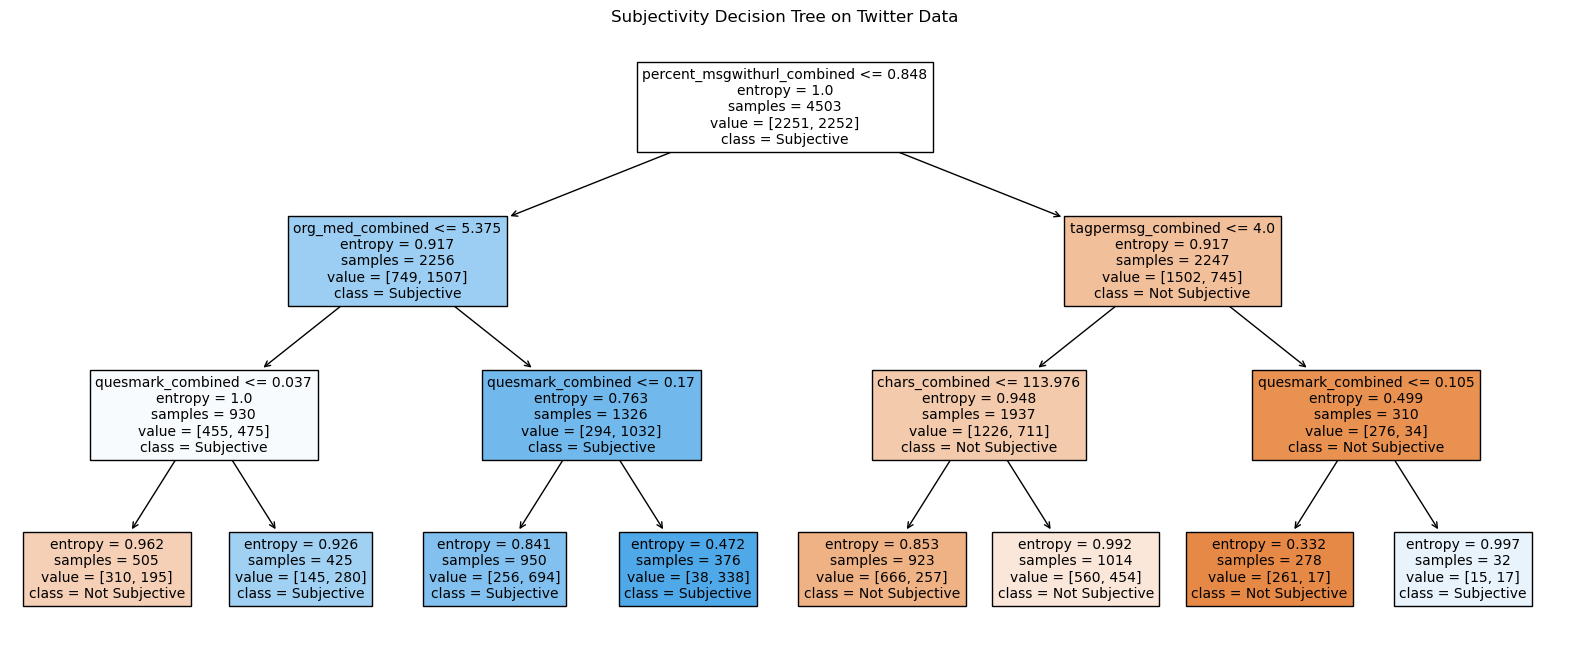

In [14]:
# Cleaner Tree (Fixed Max Depth)
dt_twitter = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                    min_samples_split=BEST_MIN_SPLIT, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=4)
scores = cross_val_score(dt_twitter, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Mean Score: {round(np.mean(scores),3)} Std Score: {round(np.std(scores), 3)}")
dt_twitter.fit(X,y)

plt.figure(figsize=(20,8))
plot_tree(dt_twitter,
          feature_names=FEATURES,
          class_names=['Not Subjective', 'Subjective'],
          filled=True,
          fontsize=10)
plt.title('Subjectivity Decision Tree on Twitter Data')
plt.show()
#plt.savefig('decision_tree.png')

Mean Score: 0.703 Std Score: 0.019


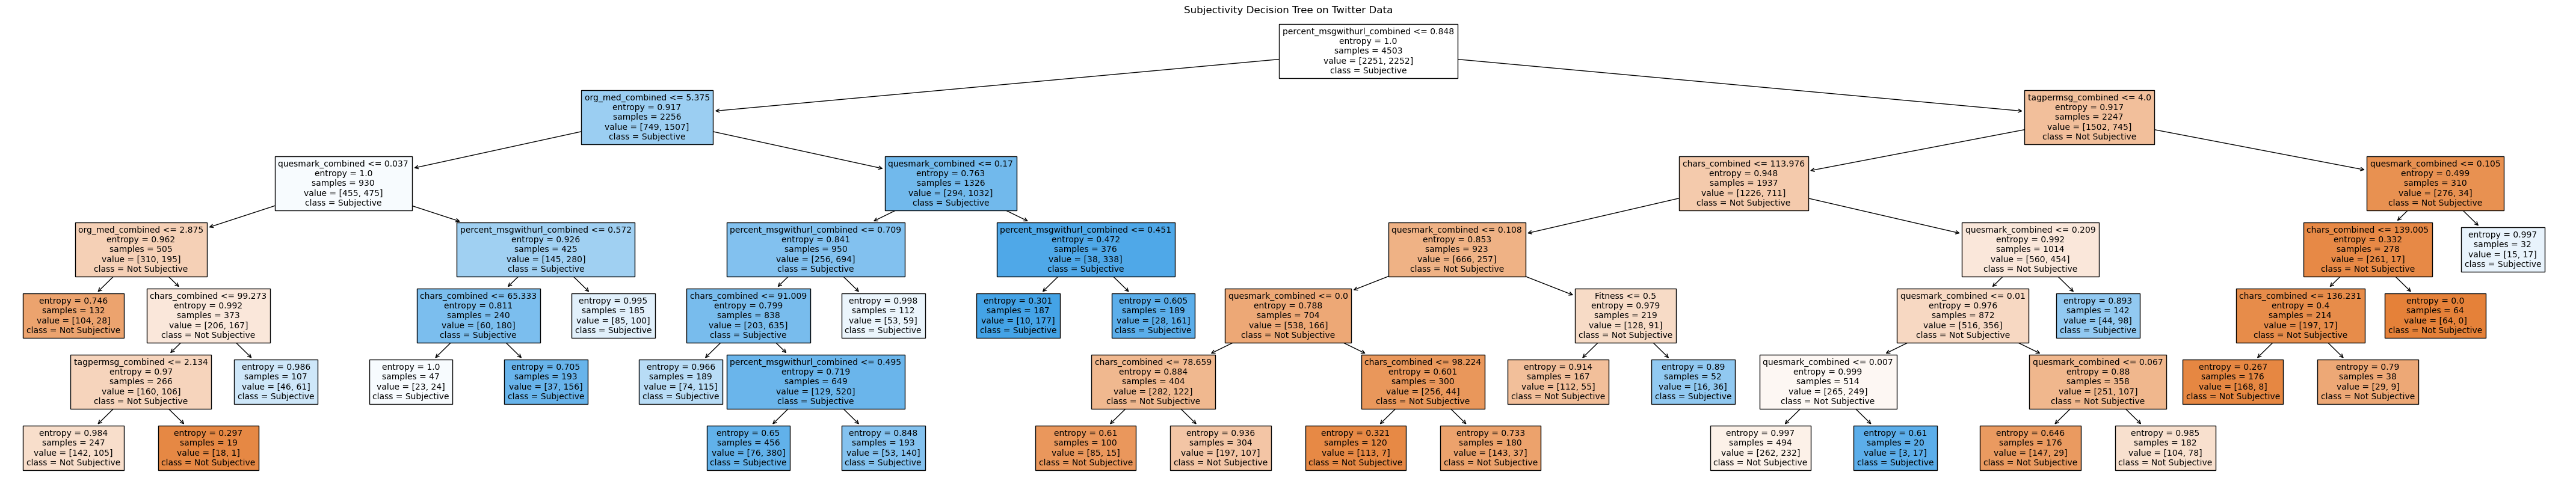

In [15]:
# For a more complex model where max_depth = 8, we can achieve a accuracy_score of 70%

dt_twitter = DecisionTreeClassifier(criterion='entropy', max_depth=BEST_MAX_DEPTH, 
                    min_samples_split=BEST_MIN_SPLIT, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=4)
scores = cross_val_score(dt_twitter, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"Mean Score: {round(np.mean(scores),3)} Std Score: {round(np.std(scores), 3)}")
dt_twitter.fit(X,y)

plt.figure(figsize=(55,10))
plot_tree(dt_twitter,
          feature_names=FEATURES,
          class_names=['Not Subjective', 'Subjective'],
          filled=True,
          fontsize=10)
plt.title('Subjectivity Decision Tree on Twitter Data')
plt.show()
#plt.savefig('decision_tree.png')


In [16]:
BEST_MAX_DEPTH

6

In [17]:
BEST_MIN_SPLIT

212

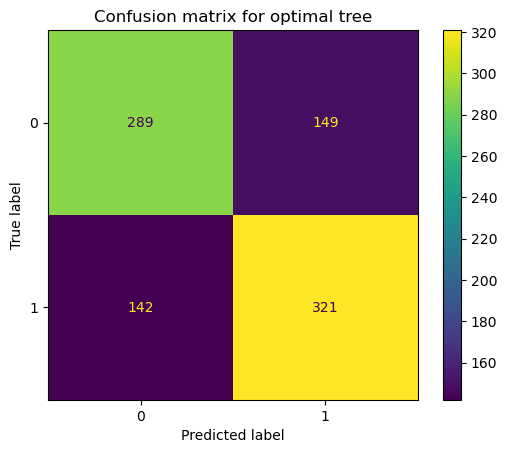

In [26]:
# Confusion matrix
dt_twitter = DecisionTreeClassifier(criterion='entropy', max_depth=BEST_MAX_DEPTH, 
                    min_samples_split=BEST_MIN_SPLIT, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
dt_twitter.fit(X_train, y_train)
y_pred=dt_twitter.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=dt_twitter.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_twitter.classes_).plot()
plt.title('Confusion matrix for optimal tree')
plt.savefig('decision Tree Graphs/confusion_matrix_optimal.png')
plt.show()



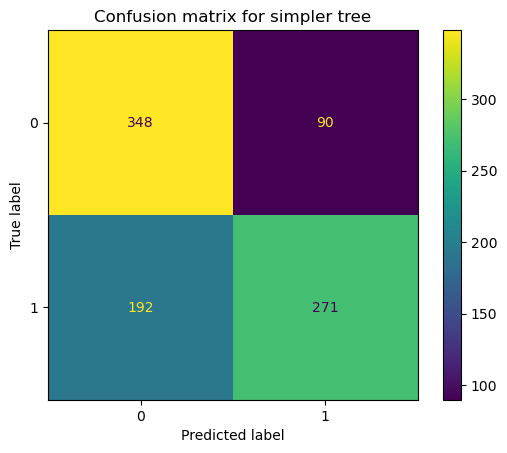

In [25]:
# Confusion matrix
dt_twitter = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                    min_samples_split=BEST_MIN_SPLIT, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test
dt_twitter.fit(X_train, y_train)
y_pred=dt_twitter.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=dt_twitter.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_twitter.classes_).plot()
plt.title('Confusion matrix for simpler tree')
plt.savefig('decision Tree Graphs/confusion_matrix_simpler.png')
plt.show()
